In [2]:
pip install scikit-image

  Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   -- ------------------------------------- 0.8/12.9 MB 2.1 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/12.9 MB 2.5 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/12.9 MB 2.8 MB/s eta 0:00:04
   -------- ------------------------------- 2.9/12.9 MB 3.0 MB/s eta 0:00:04
   ------------ --------------------------- 3.9/12.9 MB 3.3 MB/s eta 0:00:03
   --------------- ------------------------ 5.0/12.9 MB 3.6 MB/s eta 0:00:03
   -------------------- ------------------- 6.6/12.9 MB 4.0 MB/s eta 0:00:02
   ------------------------- -------------- 8.1/12.9 MB 4.4 MB/s eta 0:00:02
   ------------------------------ --------- 9.7/12.9 MB 4.7 MB/s eta 0:00:01
   ---------------------------------- ----- 11.3/12.9 MB 5.0 MB/s eta 0:00:01
   ---------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.14 requires protobuf<5,>=4.25.3, but you have protobuf 5.29.4 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.color import gray2rgb
import matplotlib.pyplot as plt

# Compatibility fix for older code
np.bool = np.bool_  # Only needed for older versions of NumPy

# Image properties
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Paths
TRAIN_PATH = 'Training_Images/'
MASK_PATH = 'Ground_Truth/'

# Load all image filenames
train_ids = [f for f in os.listdir(TRAIN_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Create empty arrays for input and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Function to read and resize images
def read_image(image_id):
    img = imread(os.path.join(TRAIN_PATH, image_id))
    if img.ndim == 2:  # Grayscale image
        img = gray2rgb(img)
    elif img.shape[2] == 4:  # Remove alpha channel if present
        img = img[:, :, :3]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    return img.astype(np.uint8)

# Function to read and resize masks
def read_mask(image_id):
    # Ensure the mask has the same filename (but .png extension)
    mask_name = os.path.splitext(image_id)[0] + '.png'
    mask = imread(os.path.join(MASK_PATH, mask_name), as_gray=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)  # shape: (128, 128, 1)
    return mask > 0.5  # Binarize the mask

# Load images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    X_train[n] = read_image(id_)
    Y_train[n] = read_mask(id_)

# Print shapes
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

# Save data if needed
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)

100%|██████████| 290/290 [00:47<00:00,  6.15it/s]


X_train shape: (290, 128, 128, 3)
Y_train shape: (290, 128, 128, 1)


In [4]:
import tensorflow as tf

In [5]:
inputs = tf.keras.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal',activation='relu', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c5)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c6)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c7)
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c8)
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), kernel_initializer='he_normal', activation='relu', padding='same')(c9)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch{epoch:02d}_val{val_loss:.4f}.h5',  # Save with epoch number & val loss
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Set to True if you want to save only weights
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=50,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/50


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6969 - loss: 0.6574
Epoch 1: val_loss improved from inf to 0.66324, saving model to model_epoch01_val0.6632.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6971 - loss: 0.6558 - val_accuracy: 0.6168 - val_loss: 0.6632
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6988 - loss: 0.6204
Epoch 2: val_loss improved from 0.66324 to 0.64953, saving model to model_epoch02_val0.6495.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6992 - loss: 0.6193 - val_accuracy: 0.6168 - val_loss: 0.6495
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7028 - loss: 0.5943
Epoch 3: val_loss did not improve from 0.64953
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7028 - loss: 0.5940 - val_accuracy: 0.6168 - val_loss: 0.6655
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7181 - loss: 0.5536
Epoch 4: val_loss did not improve from 0.64953
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.7191 - loss: 0.5525 - val_accuracy: 0.6380 - val_loss: 0.7018
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7554 - loss: 0.5114
Epoch 5: val_loss did not improve from 0.64953
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7572 - loss: 0.5087 - val_accuracy: 0.6415 - val_loss: 0.6615
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7968 - loss: 0.4531
Epoch 6: val_loss did not improve from 0.64953
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step

9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7932 - loss: 0.4473 - val_accuracy: 0.6962 - val_loss: 0.5122
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8125 - loss: 0.4193
Epoch 8: val_loss did not improve from 0.51217
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8125 - loss: 0.4190 - val_accuracy: 0.6445 - val_loss: 0.7387
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7951 - loss: 0.4462
Epoch 9: val_loss improved from 0.51217 to 0.44480, saving model to model_epoch09_val0.4448.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7956 - loss: 0.4453 - val_accuracy: 0.7853 - val_loss: 0.4448
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8278 - loss: 0.3864
Epoch 10: val_loss improved from 0.44480 to 0.42579, saving model to model_epoch10_val0.4258.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8282 - loss: 0.3859 - val_accuracy: 0.7962 - val_loss: 0.4258
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8303 - loss: 0.3840
Epoch 11: val_loss did not improve from 0.42579
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8313 - loss: 0.3822 - val_accuracy: 0.7974 - val_loss: 0.5035
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8549 - loss: 0.3430
Epoch 12: val_loss did not improve from 0.42579
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8545 - loss: 0.3433 - val_accuracy: 0.7627 - val_loss: 0.4967
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8410 - loss: 0.3599
Epoch 13: val_loss improved from 0.42579 to 0.35415, saving model to model_epoch13_val0.3541.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8421 - loss: 0.3580 - val_accuracy: 0.8554 - val_loss: 0.3541
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8649 - loss: 0.3169
Epoch 14: val_loss did not improve from 0.35415
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8646 - loss: 0.3174 - val_accuracy: 0.8477 - val_loss: 0.3904
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8666 - loss: 0.3146
Epoch 15: val_loss did not improve from 0.35415
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8665 - loss: 0.3145 - val_accuracy: 0.8097 - val_loss: 0.4453
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8633 - loss: 0.3148
Epoch 16: val_loss improved from 0.35415 to 0.30810, saving model to model_epoch16_val0.3081.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8634 - loss: 0.3148 - val_accuracy: 0.8811 - val_loss: 0.3081
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8832 - loss: 0.2793
Epoch 17: val_loss did not improve from 0.30810
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8826 - loss: 0.2803 - val_accuracy: 0.8681 - val_loss: 0.3304
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8830 - loss: 0.2781
Epoch 18: val_loss improved from 0.30810 to 0.27214, saving model to model_epoch18_val0.2721.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8831 - loss: 0.2777 - val_accuracy: 0.8964 - val_loss: 0.2721
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8978 - loss: 0.2458
Epoch 19: val_loss did not improve from 0.27214
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8968 - loss: 0.2477 - val_accuracy: 0.8786 - val_loss: 0.2971
Epoch 20/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8798 - loss: 0.2751
Epoch 20: val_loss did not improve from 0.27214
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8801 - loss: 0.2748 - val_accuracy: 0.8318 - val_loss: 0.4297
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8836 - loss: 0.2789
Epoch 21: val_loss did not improve from 0.27214
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8830 - loss: 0.2796 - val_accuracy: 0.8924 - val_loss: 0.2778
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8892 - loss: 0.2612
Epoch 22: val_loss improved from 0.27214 to 0.25359, saving model to model_e

9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.8896 - loss: 0.2606 - val_accuracy: 0.8999 - val_loss: 0.2536
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8880 - loss: 0.2693
Epoch 23: val_loss did not improve from 0.25359
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8867 - loss: 0.2713 - val_accuracy: 0.8631 - val_loss: 0.3189
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8896 - loss: 0.2542
Epoch 24: val_loss did not improve from 0.25359
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8897 - loss: 0.2544 - val_accuracy: 0.8908 - val_loss: 0.2661
Epoch 25/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8870 - loss: 0.2727
Epoch 25: val_loss did not improve from 0.25359
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8877 - loss: 0.2712 - val_accuracy: 0.8979 - val_loss: 0.2683
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9037 - loss: 0.2334
Epoch 26: val_loss did not improve from 0.25359
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9116 - loss: 0.2103 - val_accuracy: 0.9070 - val_loss: 0.2533
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9229 - loss: 0.1875
Epoch 28: val_loss did not improve from 0.25327
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9226 - loss: 0.1881 - val_accuracy: 0.8986 - val_loss: 0.2662
Epoch 29/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9145 - loss: 0.2064
Epoch 29: val_loss did not improve from 0.25327
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9146 - loss: 0.2060 - val_accuracy: 0.8921 - val_loss: 0.2997
Epoch 30/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9157 - loss: 0.2045
Epoch 30: val_loss did not improve from 0.25327
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9160 - loss: 0.2036 - val_accuracy: 0.8874 - val_loss: 0.3055
Epoch 31/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9156 - loss: 0.2070
Epoch 31: val_loss did not improve from 0.25327
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s

9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9231 - loss: 0.1875 - val_accuracy: 0.9070 - val_loss: 0.2406
Epoch 33/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9279 - loss: 0.1816
Epoch 33: val_loss did not improve from 0.24057
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9279 - loss: 0.1813 - val_accuracy: 0.8983 - val_loss: 0.3126
Epoch 34/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9316 - loss: 0.1649
Epoch 34: val_loss did not improve from 0.24057
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9315 - loss: 0.1653 - val_accuracy: 0.9035 - val_loss: 0.2562
Epoch 35/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9395 - loss: 0.1519
Epoch 35: val_loss did not improve from 0.24057
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9392 - loss: 0.1523 - val_accuracy: 0.8950 - val_loss: 0.2717
Epoch 36/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9431 - loss: 0.1432
Epoch 36: val_loss did not improve from 0.24057
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


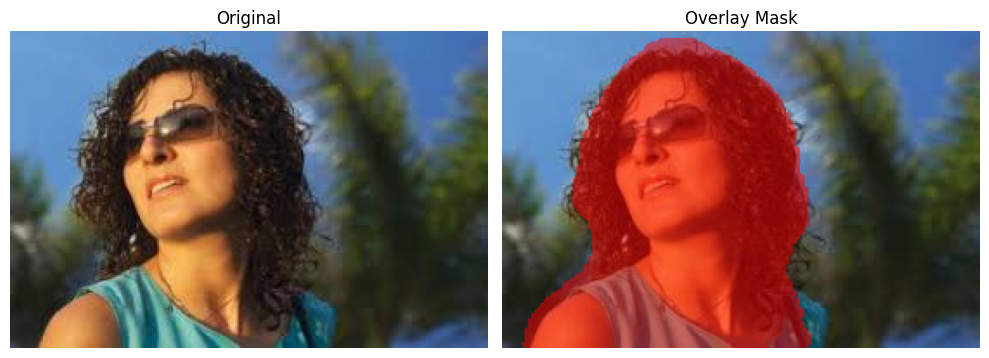

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


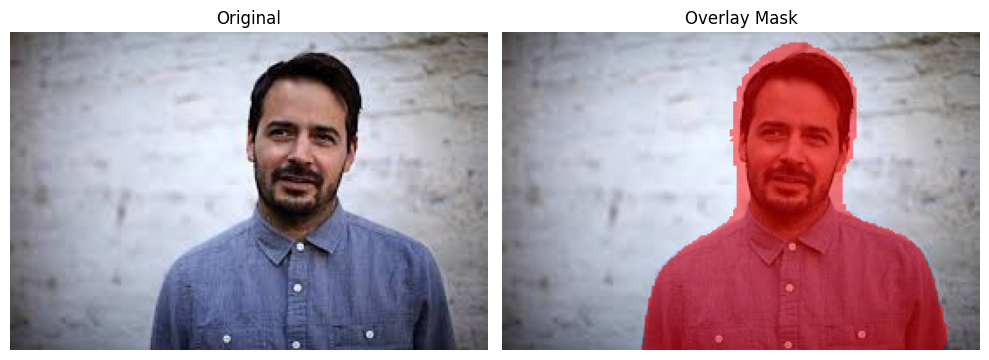

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


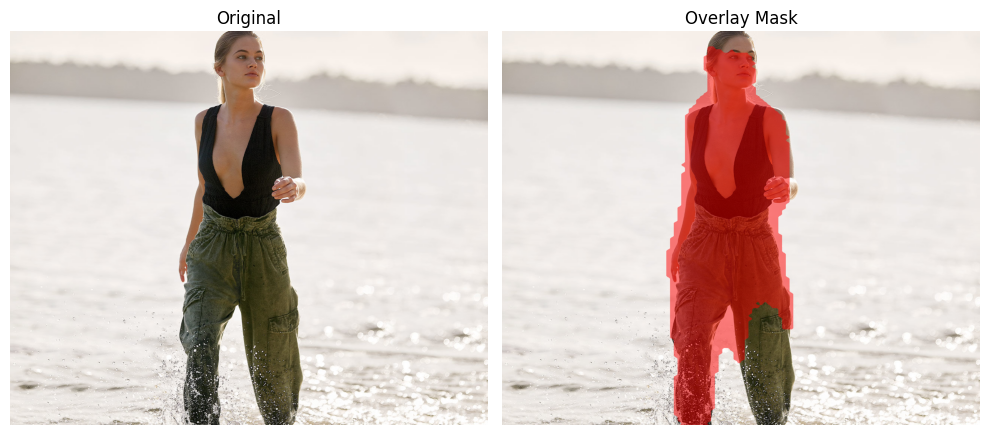

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


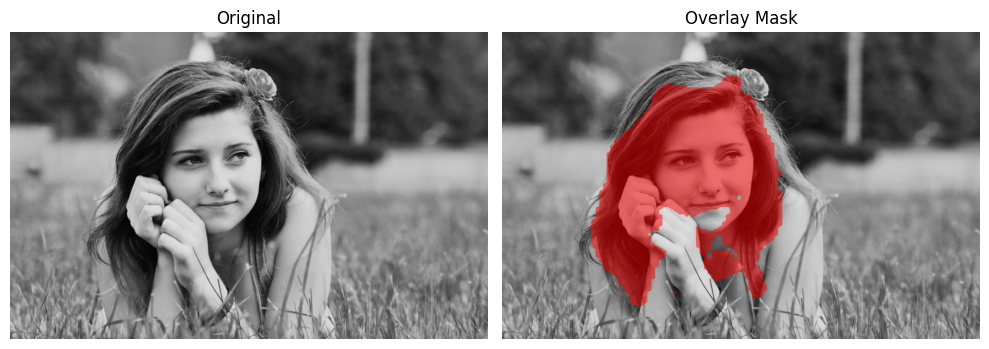

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


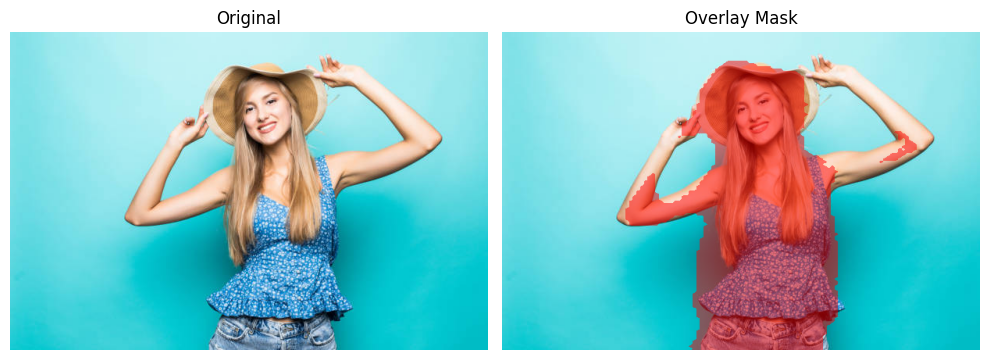

In [11]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
NUM_IMAGES = 5  # number of test images
test_folder = r'C:\Users\hp\Desktop\Jainil\image_seg\Human-Segmentation-Dataset-master\Training_Images'

# === IMAGE LIST ===
test_images = [f for f in os.listdir(test_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_images = test_images[:NUM_IMAGES]

# === INFERENCE & OVERLAY ===
for image_name in test_images:
    image_path = os.path.join(test_folder, image_name)
    original = imread(image_path)

    # Resize for prediction
    resized = resize(original, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    input_img = np.expand_dims(resized, axis=0)

    # Predict
    pred = model.predict(input_img)[0]

    # Get binary mask
    if pred.shape[-1] > 1:
        mask = np.argmax(pred, axis=-1)
    else:
        mask = (pred.squeeze() > 0.5).astype(np.uint8)

    # Resize mask back to original image size
    mask_resized = resize(mask, (original.shape[0], original.shape[1]), preserve_range=True)
    mask_resized = (mask_resized > 0.5).astype(np.uint8)

    # Create overlay: red mask
    overlay = original.copy()
    if overlay.ndim == 2 or overlay.shape[2] == 1:  # grayscale image
        overlay = np.stack([overlay] * 3, axis=-1)

    # Red mask overlay
    red = np.zeros_like(overlay)
    red[..., 0] = 255  # red channel

    alpha = 0.5  # transparency
    overlay = np.where(mask_resized[..., None], 
                       (1 - alpha) * overlay + alpha * red, 
                       overlay).astype(np.uint8)

    # Show both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
